# Clone my driving behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
user = !whoami
user = user[0]

In [3]:
IMAGE_SHAPE = (160, 320, 3)
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'

## Load images and measurements

In [4]:
def load_images_and_measurements(image_set_directory):
    driving_log = (
        pd.read_csv(
            f'./my-videos/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    raw_images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    flipped_images = np.flip(raw_images, axis=2)

    images = np.vstack([raw_images, flipped_images])
    
    raw_measurements = driving_log['steering_angle']
    measurements_flipped = - raw_measurements

    measurements = np.hstack([raw_measurements, measurements_flipped])
    
    return images, measurements

In [5]:
def load_image_sets(image_set_names):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [16]:
%%time
train_images, train_meas = load_image_sets([
    'first_drives', 
    '3_forward_rounds', 
    '3_backward_rounds'
])
print(f'Number of training samples: {train_meas.shape[0]}')

Number of training samples: 16720
CPU times: user 13.1 s, sys: 1.82 s, total: 14.9 s
Wall time: 14.9 s


In [7]:
valid_images, valid_meas = load_image_sets(['2_rounds_for_testing'])
print(f'Number of validation samples: {valid_meas.shape[0]}')

Number of validation samples: 6350


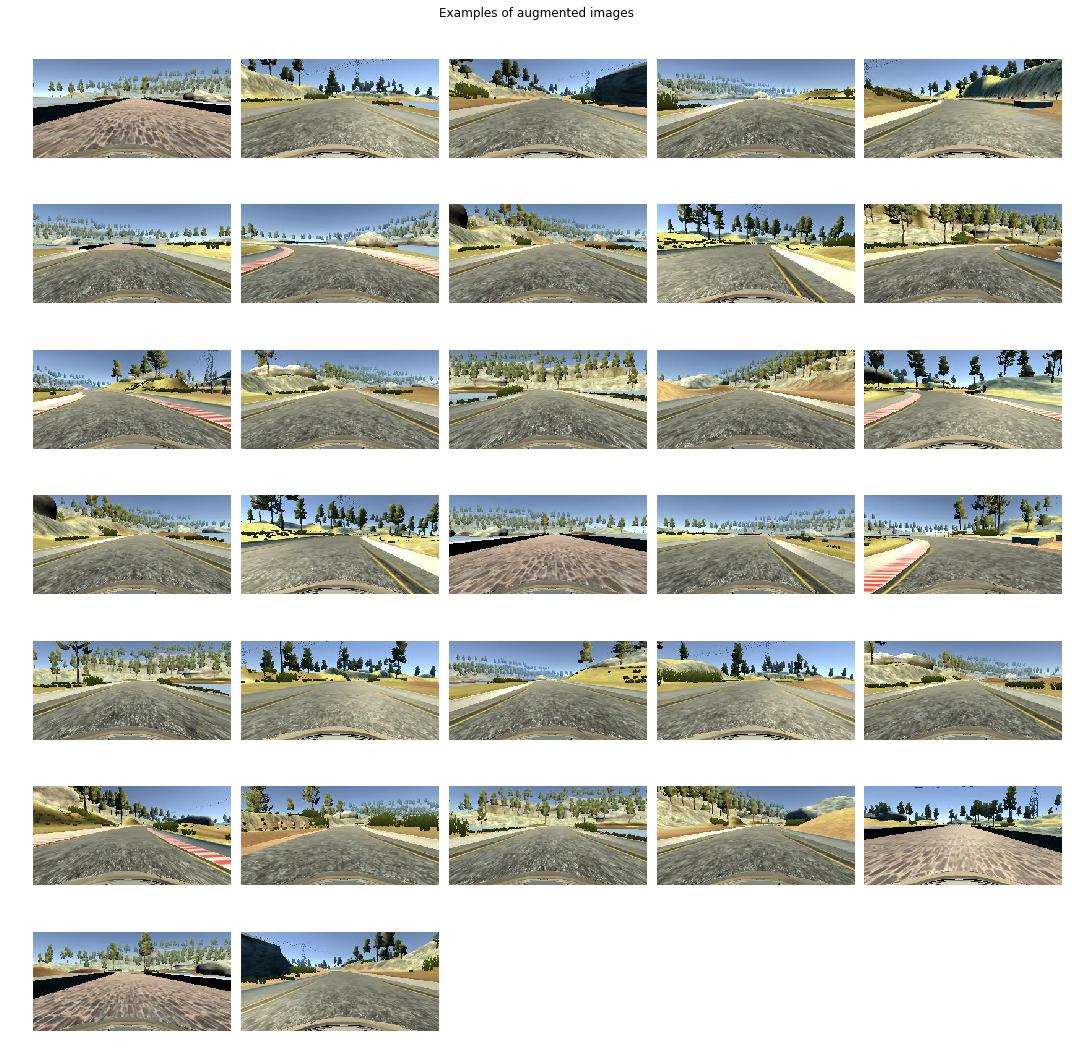

In [9]:
# train_datagen = ImageDataGenerator()
# train_generator = train_datagen.flow(train_images, train_meas, batch_size=32)

# fig, axes = plt.subplots(7, 5, figsize=(15, 15))

# for i, image in enumerate(next(train_generator)[0].astype('uint8')):
#     row, col = i // 5, i % 5
#     axes[row, col].axis('off')
#     axes[row, col].imshow(image)
    
# for i in range(32, 35):
#     row, col = i // 5, i % 5
#     fig.delaxes(axes[row, col])

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)
# fig.suptitle('Examples of augmented images')
# plt.subplots_adjust(wspace=.05, hspace=.05)
# plt.show()

## Define model

In [17]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE),
    Lambda(lambda x: x / 255.0 - 0.5),
    
    Conv2D(24, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
batch_normalization_17 (Batc (None, 31, 158, 24)       96        
_________________________________________________________________
activation_17 (Activation)   (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 77, 36)        144       
__________

## Train model

In [19]:
%%time
# steps_per_epoch = int(train_meas.shape[0] * .8 / 32)

model.fit(
    train_images,
    train_meas,
    epochs=1,
    validation_data=[valid_images, valid_meas]
)

Train on 16720 samples, validate on 6350 samples
Epoch 1/1
16720/16720 [==============================] - 24s 1ms/step - loss: 0.0901 - val_loss: 0.0077
CPU times: user 25.2 s, sys: 2.61 s, total: 27.9 s
Wall time: 25.4 s


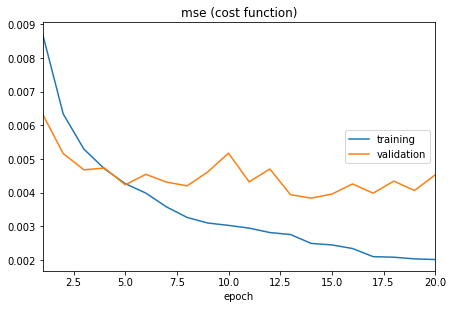

mse (cost function):
training   (min:    0.002, max:    0.009, cur:    0.002)
validation (min:    0.004, max:    0.006, cur:    0.005)
CPU times: user 7min 49s, sys: 1min 1s, total: 8min 51s
Wall time: 7min 48s


In [21]:
%%time
model.fit(
    train_images,
    train_meas,
    epochs=20,
    callbacks=[PlotLossesKeras()],
    validation_data=[valid_images, valid_meas]
)

In [22]:
model.save('./models/model_nvidia_added_3_rounds_forward_dataset.h5a')

In [23]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_added_3_rounds_forward_dataset.h5a to s3://behavioral-cloning-models/model_nvidia_added_3_rounds_forward_dataset.h5a


## Compare original and predicted angle distributions

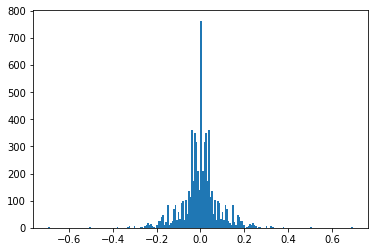

In [25]:
plt.hist(valid_meas, bins=200)
plt.show()

In [26]:
%%time
predictions = model.predict(valid_images)

CPU times: user 3.36 s, sys: 176 ms, total: 3.53 s
Wall time: 4.67 s


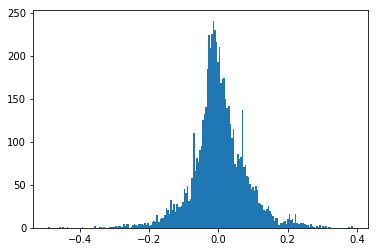

In [27]:
plt.hist(predictions, bins=200)
plt.show()

## Visualize output of convolution layers

In [28]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name or 'cropping2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

In [29]:
def plot_layer_channels(layer, name):
    number_of_channels = layer.shape[2]
    square_size = int(np.ceil(np.sqrt(number_of_channels)))

    fig, axes = plt.subplots(nrows=square_size, ncols=square_size, figsize=(20,20))
    for idx, image in enumerate(layer.transpose(2, 0, 1)):
        row = idx // square_size
        col = idx % square_size
        axes[row, col].axis('off')
        axes[row, col].imshow(image, cmap='gray', aspect='auto')

    for idx in [i for i in range(square_size ** 2) if i >= number_of_channels]:
        row = idx // square_size
        col = idx % square_size
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f'Channels of layer {name}', fontsize=18)
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [30]:
def plot_layers(input_image, evaluation_functions):
    layer_outputs = evaluation_functions([[input_image], 0.])
    
    plt.title('Input image')
    plt.imshow(input_image)
    plt.show()
    
    plt.title('Cropped image')
    plt.imshow(layer_outputs[0][0].astype('uint8'))
    plt.show()
    
    for layer, name in zip(layer_outputs[1:], layer_names[1:]):
        plot_layer_channels(layer[0], name)

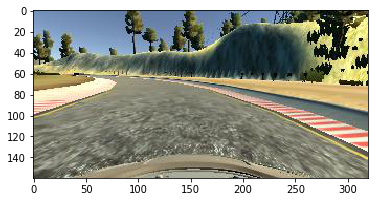

In [32]:
test_image = valid_images[0]
plt.imshow(test_image)
plt.show()

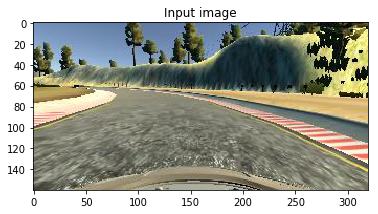

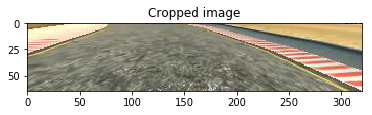

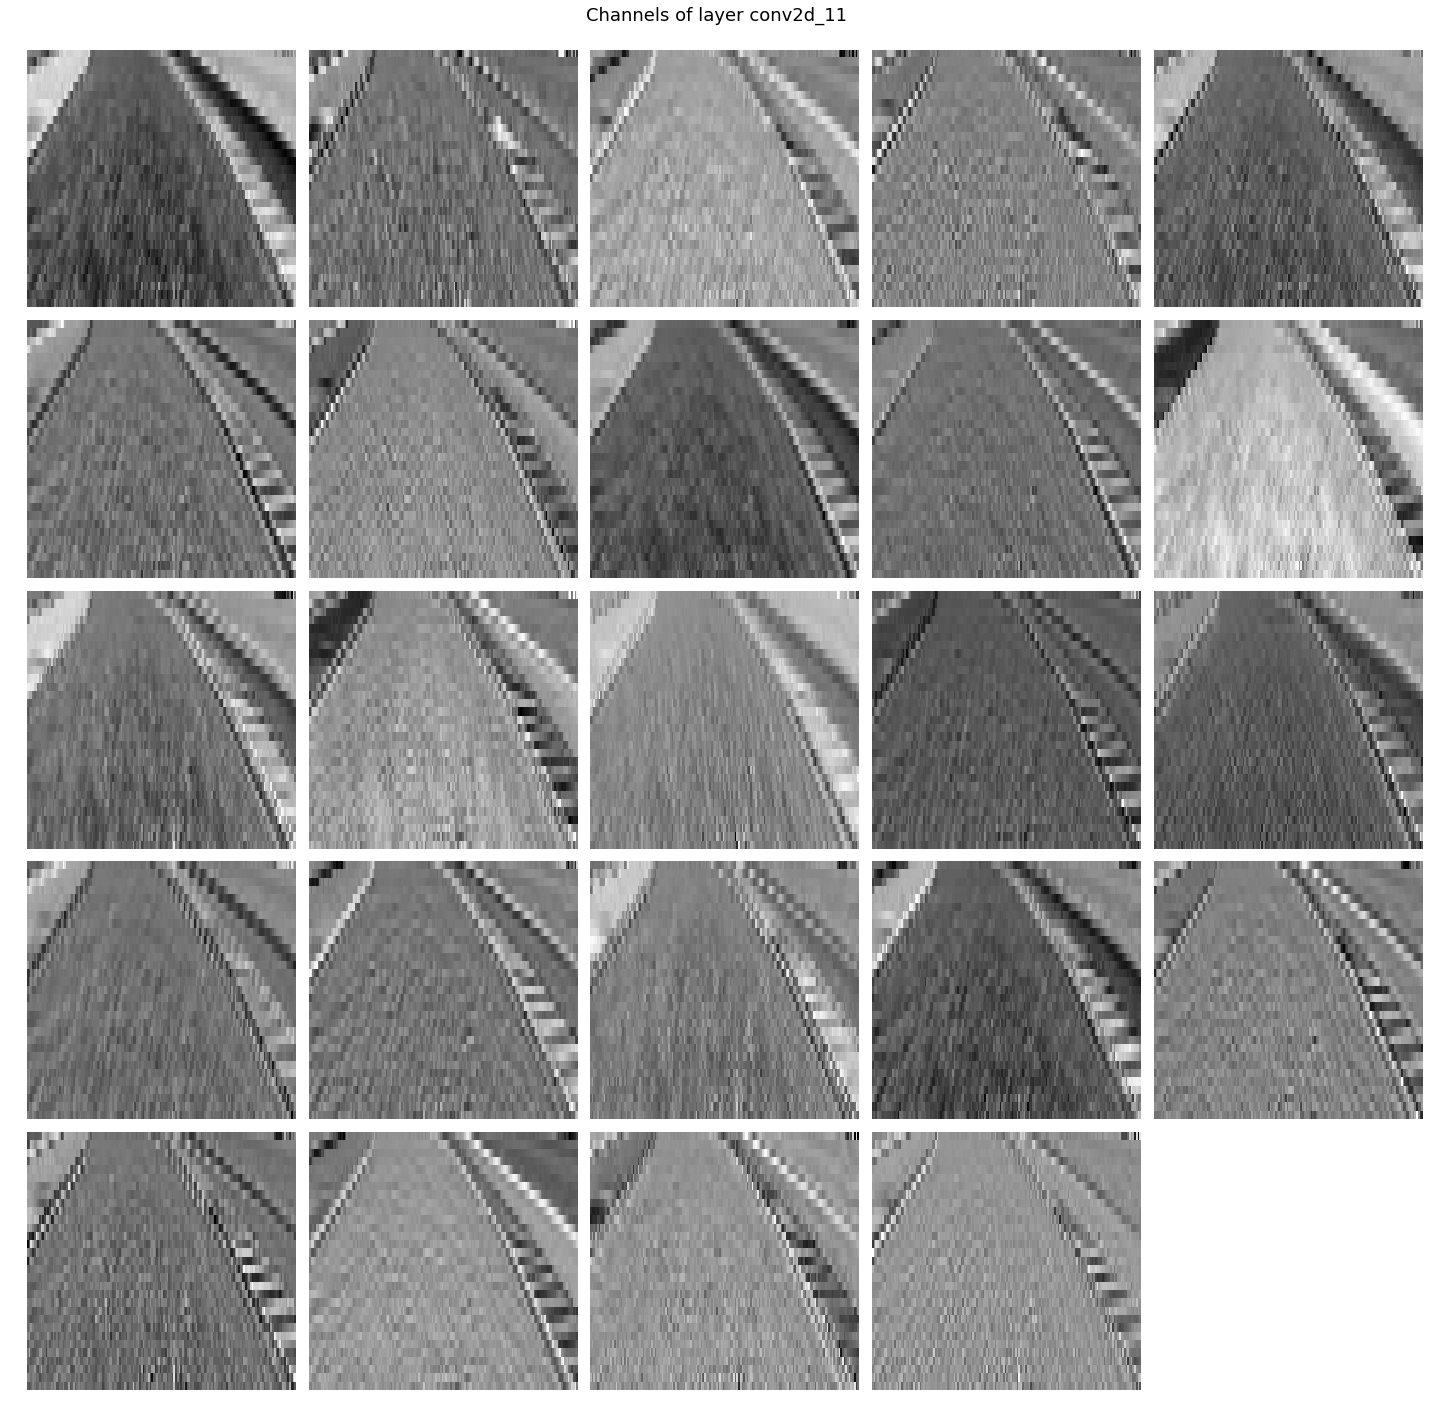

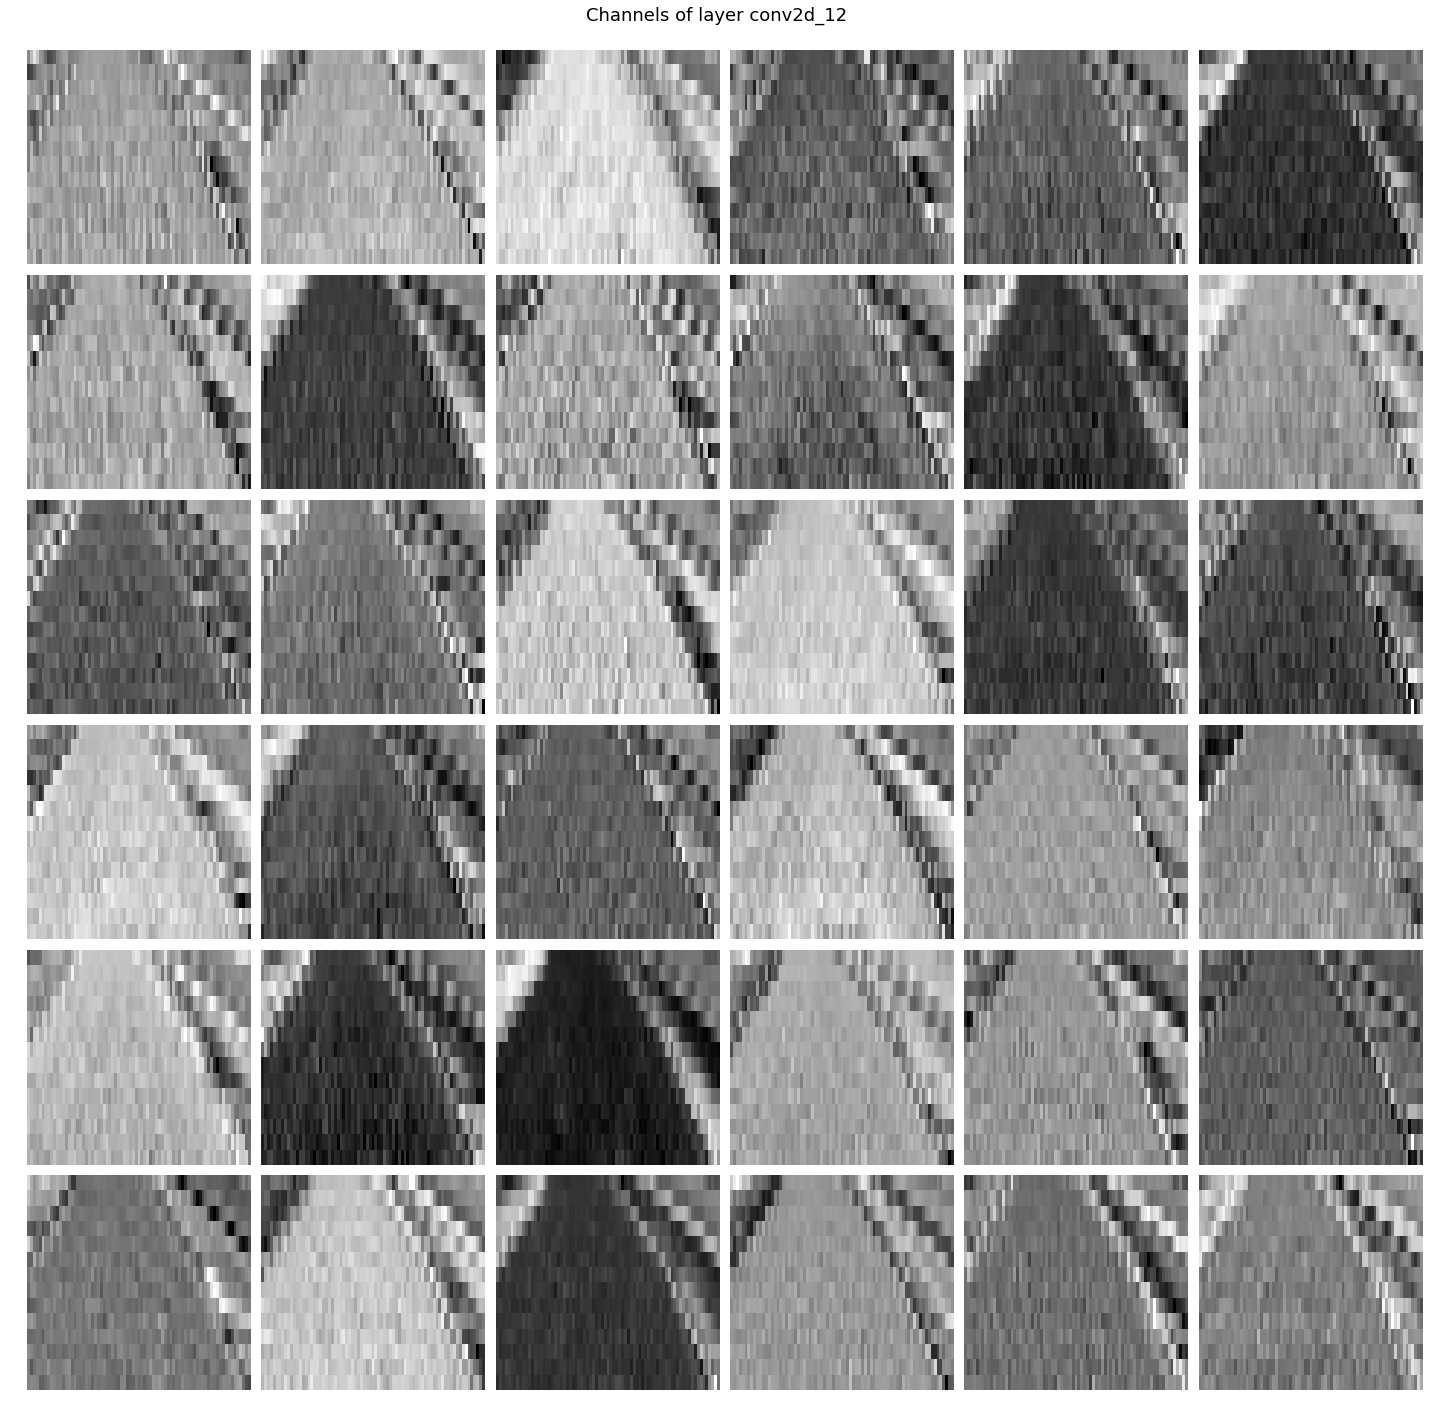

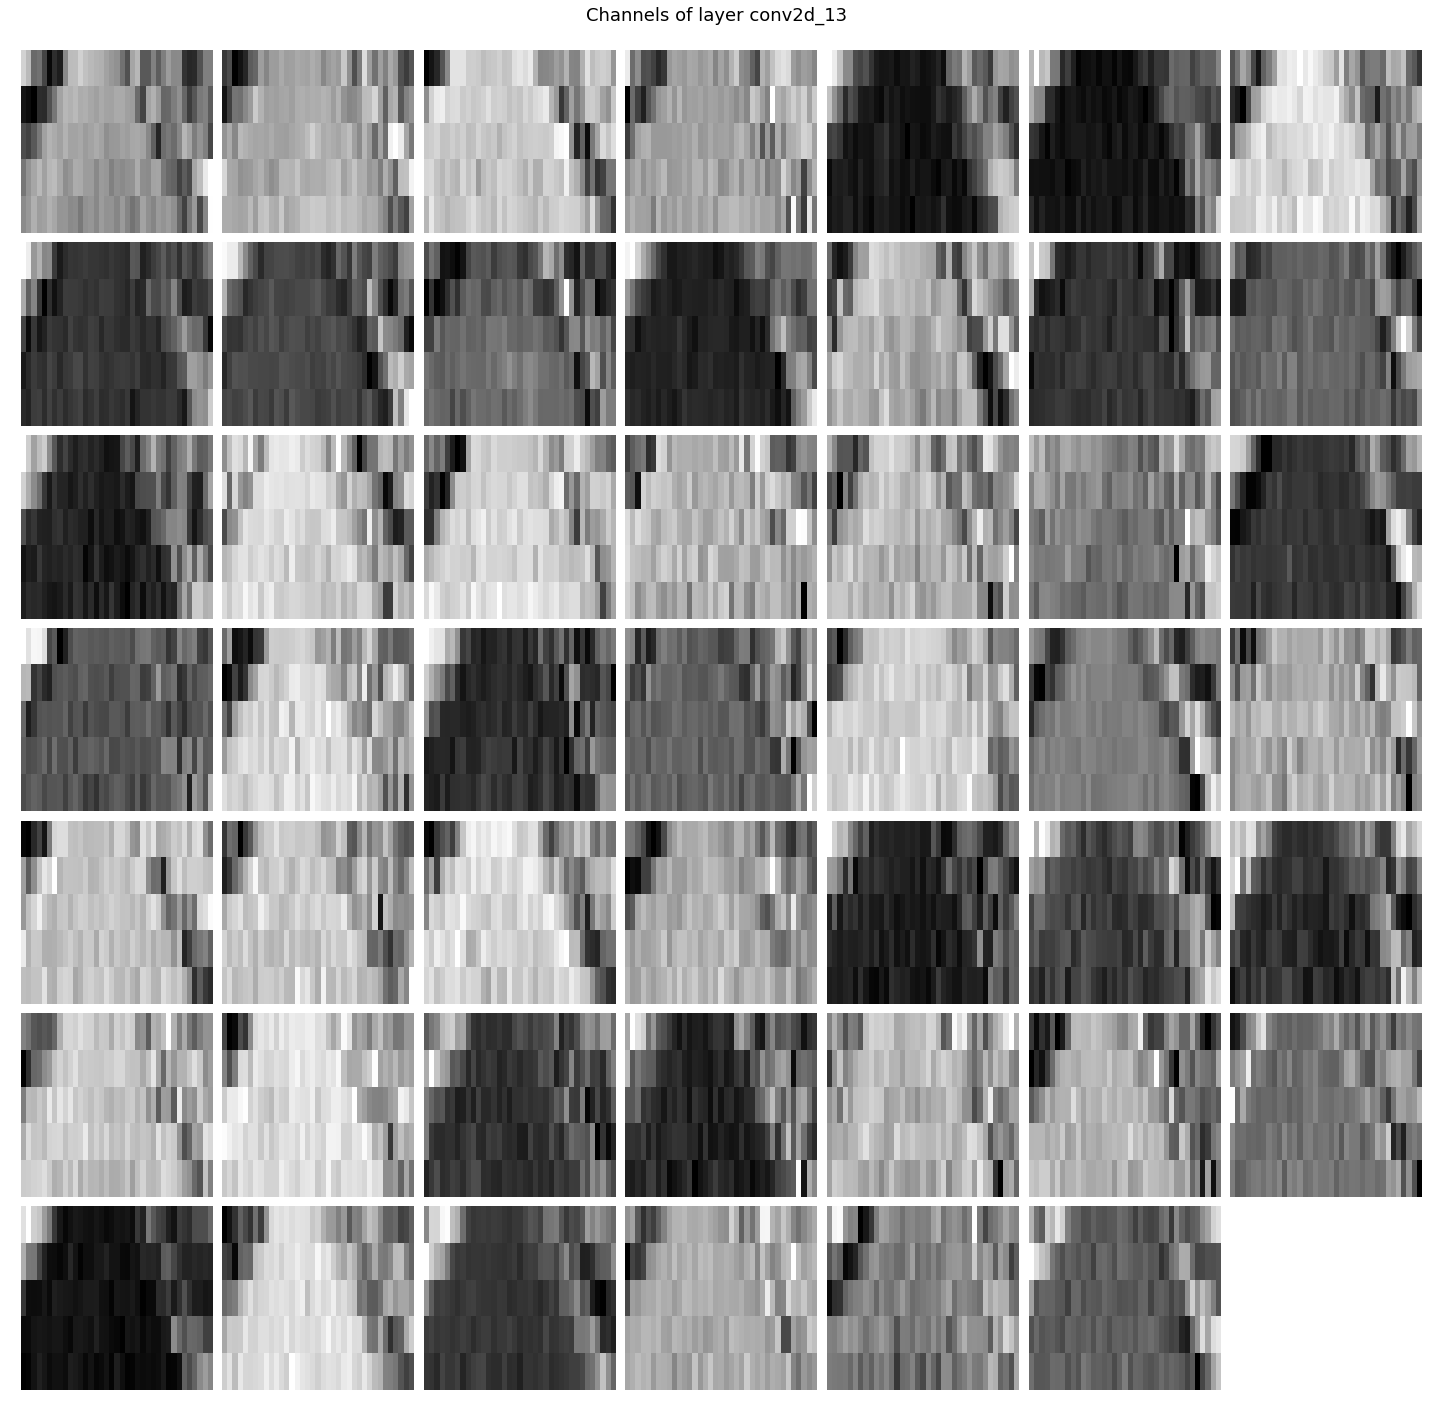

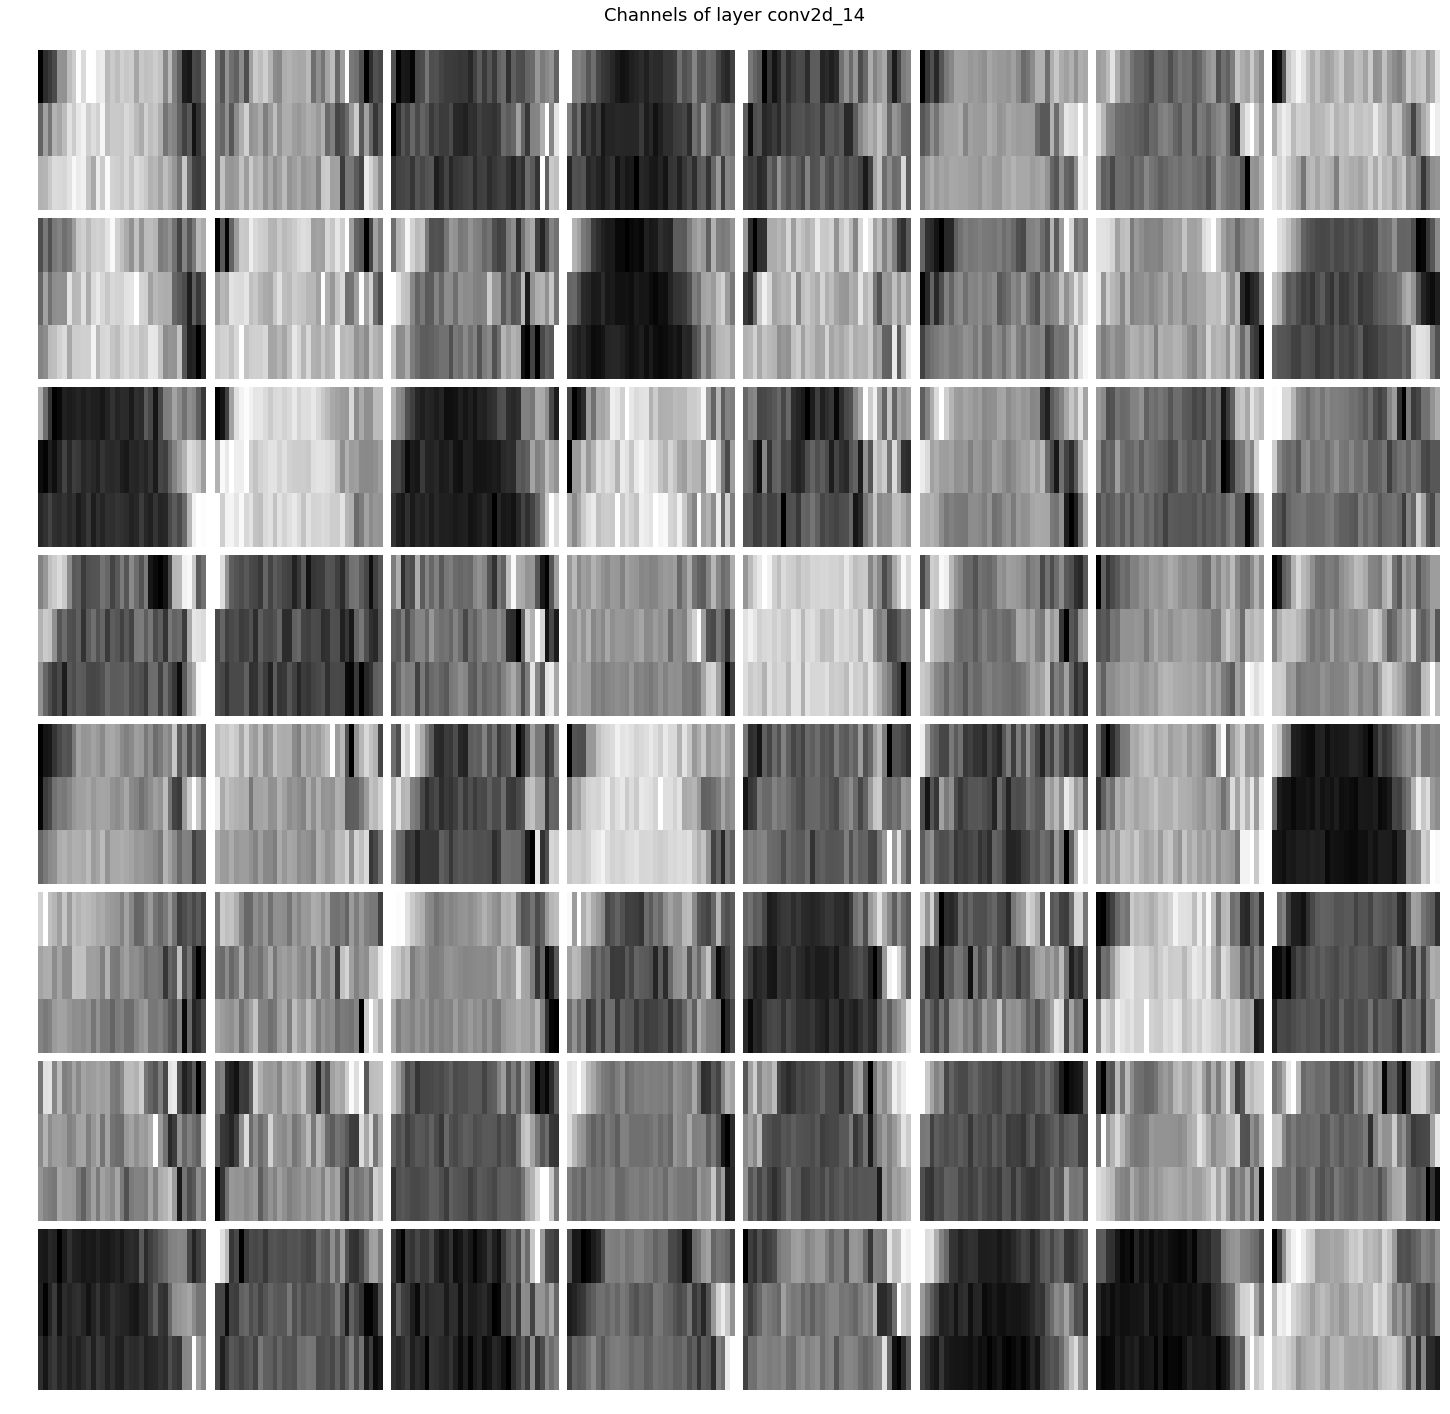

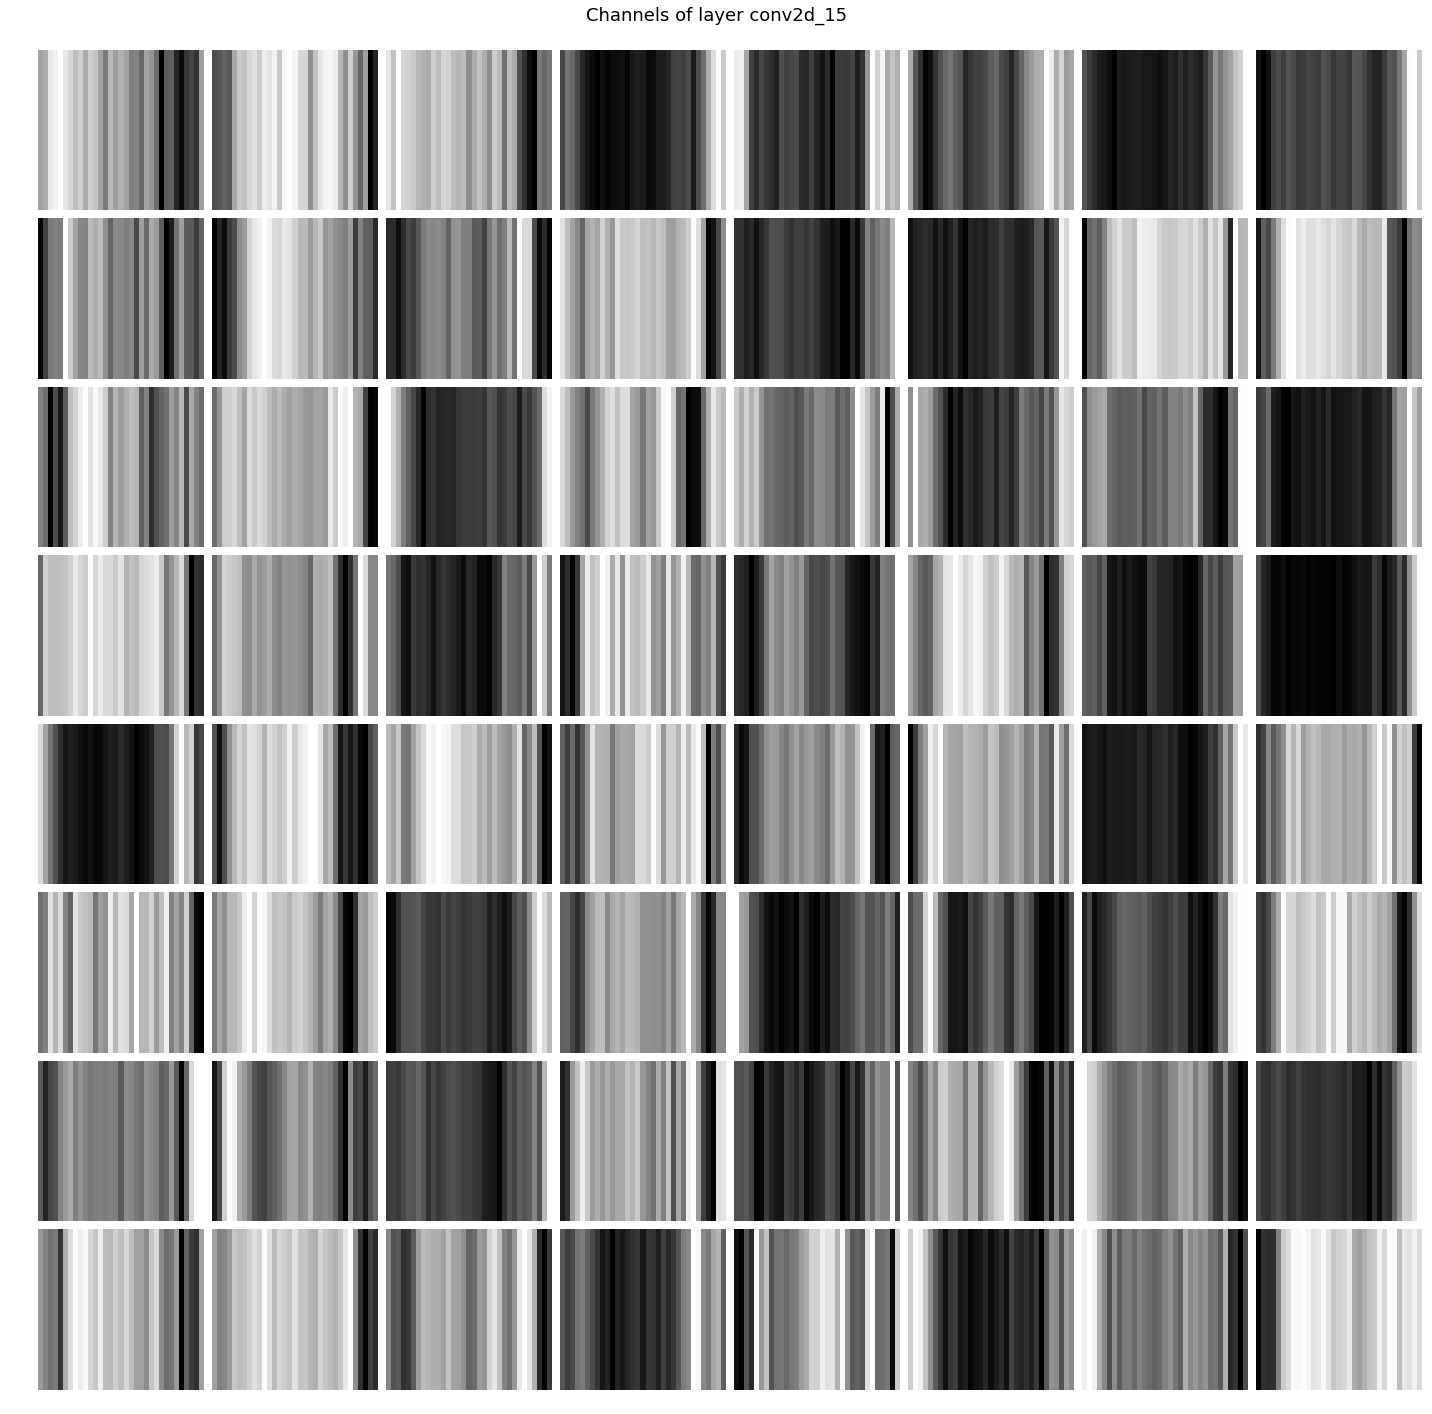

In [33]:
plot_layers(test_image, evaluation_functions)